# **주가 흐름 이상탐지를 통한 매수·매도 예측 모델 개발**

## 1. 데이터셋 가져오기

#### 1-1) 데이터 선택 및 크롤링
최근 이슈가 되는 4차 산업 관련 종목들(바이오, 5G, IT, 2차전지 등)이 포함된 ETF 상품들 중  NH-Amundi 자산운용에서 2020년 11월 10일에 상장한 ["HANARO Fn K-뉴딜디지털플러스"](https://www.nh-amundi.com/) 를 선택했고, 금융데이터 수집 라이브러리인 FinanceDataReader를 활용해 가격 데이터를 가져올 것이다.

- 참고 : [FinanceDataReader 사용자 안내서](https://financedata.github.io/posts/finance-data-reader-users-guide.html)

In [1]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
from IPython.display import Image

In [2]:
# ETF 포트폴리오 데이터 
nh_etf = pd.read_csv('nh_etf.csv')
nh_etf = nh_etf.iloc[:,1:]
nh_etf.columns = nh_etf.loc[0]
nh_etf = nh_etf.drop(nh_etf.index[0]).reset_index(drop = True)
nh_etf

,종목코드,종목명,수량(주),평가금액(원),비중(%)
0,035720,카카오,160,"80,320,000",12.88
1,035420,NAVER,206,"77,662,000",12.46
2,006400,삼성SDI,105,"68,775,000",11.03
3,036570,엔씨소프트,67,"59,295,000",9.51
4,051910,LG화학,72,"58,824,000",9.44
5,068270,셀트리온,167,"51,436,000",8.25
6,207940,삼성바이오로직스,64,"48,000,000",7.7
7,091990,셀트리온헬스케어,363,"46,572,900",7.47
8,096770,SK이노베이션,199,"46,267,500",7.42
9,003670,포스코케미칼,104,"16,900,000",2.71


In [3]:
# 종목코드, 종목명 활용
nh_etf_stock_code = nh_etf["종목코드"][:20]
nh_etf_stock = nh_etf["종목명"][:20]

#### 1-2) FinanceDataReader 라이브러리 활용

종목코드를 이용해 일별시세(시가, 종가, 저가, 고가, 거래량, 전일비) 데이터를 가져올 수 있다. 

날짜(Date)와 종가(Close) 데이터를 가공하여 데이터셋을 만든다.

In [4]:
# fdr.DataReader("종목코드", "시작 날짜", "마지막 날짜")
kakao = fdr.DataReader("035720")
kakao

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1999-11-11,4979,4979,4979,4979,12,NaN
1999-11-12,5557,5557,5557,5557,140,0.116088
1999-11-15,6224,6224,6224,6223,405,0.119849
1999-11-16,6957,6957,6957,6957,214,0.117950
1999-11-17,7780,7780,7780,7779,191,0.118154
...,...,...,...,...,...,...
2021-04-05,503000,505000,500000,502000,310400,0.001996
2021-04-06,506000,545000,505000,544000,1724958,0.083665
2021-04-07,544000,544000,526000,542000,820896,-0.003676


In [5]:
def price_data(code, start_date, n):
#     stock = fdr.DataReader(code, start_date)
    stock = fdr.DataReader(code, start_date, "2021-03-31")      # 2021년 3월까지 데이터만 활용
    stock = stock.reset_index()
    stock.columns = ["date", "open", "high", "low", "close", "volume", "change"]
    stock = stock[["date", "close"]]
    
    # N 영업일 간의 시계열 묶음으로 나타내기
    for i in range(1, n):
        stock["close_{}".format(i)] = stock["close"].shift(-i)  # 종가를 (-i)만큼 시프트하면 다음날 종가가 비교하려는 종가가 같은 행에 위치
    
    date_list = list(stock["date"][n-1:]) 
    stock = stock.dropna().reset_index(drop = True)
    stock = stock.drop(["date"], axis = 1)
    stock.insert(0, "date", date_list)
    
    # train, test set 분리 -> 2017년을 기준으로 이전은 train, 이후는 test
    train = stock[stock["date"] < "2017-01-01"].reset_index(drop = True)
    test = stock[stock["date"] >= "2017-01-01"].reset_index(drop = True)
    
    # train date 칼럼 제거
    train = train.iloc[:,1:]
    train = train.astype(np.float)
    
    # test date 저장
    test_date = test["date"]
    
    # test date 칼럼 제거
    test = test.iloc[:,1:]
    test = test.astype(np.float)
    
    return train, test, test_date

가격 데이터의 시계열 묶음 기준을 20일, 60일, 120일 세 가지 두고 비교해 볼 것이다.

묶음 기준은 주식 차트의 '이동평균선'을 따르는데, 일정 기간동안의 종가를 평균적으로 나타낸 가격을 선으로 이은 그래프다.

보통 5,10,20일까지는 단기, 60일은 중기, 120일 이상은 장기 이동 평균선이라 부른다.

20일 선은 단기 매매, 60일 선은 시장 영업일 기준 '분기별 이동평균치'이기 때문에 적당한 변동성을 반영하고, 120일 선은 국제 정세나 한 나라의 경제상황의 영향을 받는다.

![이동평균선](이동평균선.png)



In [6]:
# NH-Amundi 4차산업 ETF 구성 종목 가격 데이터 불러오기
for i in range(0, len(nh_etf_stock_code)):
    globals()["{}_train_120".format(nh_etf_stock[i])], globals()["{}_test_120".format(nh_etf_stock[i])], globals()["{}_test_date_120".format(nh_etf_stock[i])] = price_data(nh_etf_stock_code[i], "2000-01-01", 120)
    globals()["{}_train_60".format(nh_etf_stock[i])], globals()["{}_test_60".format(nh_etf_stock[i])], globals()["{}_test_date_60".format(nh_etf_stock[i])] = price_data(nh_etf_stock_code[i], "2000-01-01", 60)
    globals()["{}_train_20".format(nh_etf_stock[i])], globals()["{}_test_20".format(nh_etf_stock[i])], globals()["{}_test_date_20".format(nh_etf_stock[i])] = price_data(nh_etf_stock_code[i], "2000-01-01", 20)

In [7]:
# train데이터 : 해당 날짜부터 최대 20일까지의 종가 데이터가 한 행에 정렬된 모습
카카오_train_20.head(3)

,close,close_1,close_2,close_3,close_4,close_5,close_6,close_7,close_8,close_9,close_10,close_11,close_12,close_13,close_14,close_15,close_16,close_17,close_18,close_19
0,151373.0,133368.0,117364.0,103360.0,104472.0,116919.0,109806.0,96692.0,103805.0,116252.0,130034.0,115141.0,124921.0,122254.0,121365.0,106917.0,97803.0,86244.0,96469.0,108028.0
1,133368.0,117364.0,103360.0,104472.0,116919.0,109806.0,96692.0,103805.0,116252.0,130034.0,115141.0,124921.0,122254.0,121365.0,106917.0,97803.0,86244.0,96469.0,108028.0,120920.0
2,117364.0,103360.0,104472.0,116919.0,109806.0,96692.0,103805.0,116252.0,130034.0,115141.0,124921.0,122254.0,121365.0,106917.0,97803.0,86244.0,96469.0,108028.0,120920.0,124032.0


In [8]:
카카오_test_60.tail(3)

,close,close_1,close_2,close_3,close_4,close_5,close_6,close_7,close_8,close_9,...,close_50,close_51,close_52,close_53,close_54,close_55,close_56,close_57,close_58,close_59
1038,384500.0,389500.0,396000.0,393000.0,395500.0,402500.0,434000.0,453000.0,457500.0,454500.0,...,479000.0,485000.0,498000.0,492500.0,494000.0,490500.0,492000.0,485000.0,495000.0,487500.0
1039,389500.0,396000.0,393000.0,395500.0,402500.0,434000.0,453000.0,457500.0,454500.0,451500.0,...,485000.0,498000.0,492500.0,494000.0,490500.0,492000.0,485000.0,495000.0,487500.0,493500.0
1040,396000.0,393000.0,395500.0,402500.0,434000.0,453000.0,457500.0,454500.0,451500.0,437500.0,...,498000.0,492500.0,494000.0,490500.0,492000.0,485000.0,495000.0,487500.0,493500.0,498000.0


In [9]:
# 마지막행인 1040행의 'close_19' 컬럼이 2021년 3월 31일의 종가 
카카오_test_date_120

0      2017-01-02
1      2017-01-03
2      2017-01-04
3      2017-01-05
4      2017-01-06
          ...    
1036   2021-03-25
1037   2021-03-26
1038   2021-03-29
1039   2021-03-30
1040   2021-03-31
Name: date, Length: 1041, dtype: datetime64[ns]

## 2. 오토인코더 모델링

오토인코더 모델을 통해 주가 흐름 중 이상치에 해당하는 급등·급락, 노이즈 등을 제거한 결과값과 실제값의 변동 추이를 시각화를 통해 확인한다.

#### 2-1) 데이터셋 전처리

- train, val, test 데이터 나누기

In [10]:
# train data 생성 및 train, val 분리
from sklearn.model_selection import train_test_split

train_120 = pd.DataFrame()
train_60 = pd.DataFrame()
train_20 = pd.DataFrame()

for i in nh_etf_stock:
    train_120 = pd.concat([train_120, globals()["{}_train_120".format(i)]], axis = 0).reset_index(drop = True)   # 각 종목의 train데이터를 병합
    train_60 = pd.concat([train_60, globals()["{}_train_60".format(i)]], axis = 0).reset_index(drop = True)
    train_20 = pd.concat([train_20, globals()["{}_train_20".format(i)]], axis = 0).reset_index(drop = True)
    
train_120, val_120 = train_test_split(train_120, test_size=0.3, random_state=21)   # 날짜 정보를 사용하지 않고 랜덤한 순서로 구성.
train_60, val_60 = train_test_split(train_60, test_size=0.3, random_state=21)
train_20, val_20 = train_test_split(train_20, test_size=0.3, random_state=21)

print("120 영업일 기준: ", train_120.shape, val_120.shape)
print("60 영업일 기준: ", train_60.shape, val_60.shape)
print("20 영업일 기준: ", train_20.shape, val_20.shape)

120 영업일 기준:  (32617, 120) (13980, 120)
60 영업일 기준:  (33205, 60) (14232, 60)
20 영업일 기준:  (33609, 20) (14405, 20)


In [11]:
# 모든 test데이터는 '2017-01-02' ~ '2021-03-31' 날짜의 데이터를 차례대로 가지므로 크기가 같다.

카카오_test_20.shape, NHN한국사이버결제_test_60.shape, 셀트리온_test_120.shape

((1041, 20), (1041, 60), (1041, 120))

- MinMaxScaler :  종목별로 가격이 상이하여 모든 값이 0~1사이에 있도록 데이터를 재조정

In [12]:
from sklearn.preprocessing import MinMaxScaler

# 120 영업일 기준
scaler_120 = MinMaxScaler()
train_scaled_120 = scaler_120.fit_transform(train_120)
val_scaled_120 = scaler_120.transform(val_120)

# 60 영업일 기준
scaler_60 = MinMaxScaler()
train_scaled_60 = scaler_60.fit_transform(train_60)
val_scaled_60 = scaler_60.transform(val_60)

# 20 영업일 기준
scaler_20 = MinMaxScaler()
train_scaled_20 = scaler_20.fit_transform(train_20)
val_scaled_20 = scaler_20.transform(val_20)

#### 2-2) 모델링

120일, 60일, 20일 영업일 기준 모델 차례대로 학습

In [13]:
# AutoEncoder model - 120 영업일
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Dense(128, activation="relu"),
          layers.Dense(64, activation="relu"),
          layers.Dense(8, activation="relu")])

        self.decoder = tf.keras.Sequential([
          layers.Dense(64, activation="relu"),
          layers.Dense(128, activation="relu"),
          layers.Dense(120, activation="sigmoid")])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder_120 = AnomalyDetector()

In [14]:
# 120 영업일 기준 모델 학습
autoencoder_120.compile(optimizer='adam', loss='mae')

history_120 = autoencoder_120.fit(train_scaled_120, train_scaled_120, 
                                  epochs=30,
                                  batch_size=16,
                                  validation_data=(val_scaled_120, val_scaled_120))

Epoch 1/30
2039/2039 [==============================] - 15s 7ms/step - loss: 0.1125 - val_loss: 0.0113
Epoch 2/30
2039/2039 [==============================] - 10s 5ms/step - loss: 0.0113 - val_loss: 0.0110
Epoch 3/30
2039/2039 [==============================] - 13s 6ms/step - loss: 0.0096 - val_loss: 0.0074
Epoch 4/30
2039/2039 [==============================] - 11s 5ms/step - loss: 0.0072 - val_loss: 0.0070
Epoch 5/30
2039/2039 [==============================] - 7s 3ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 6/30
2039/2039 [==============================] - 8s 4ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 7/30
2039/2039 [==============================] - 11s 5ms/step - loss: 0.0057 - val_loss: 0.0055
Epoch 8/30
2039/2039 [==============================] - 10s 5ms/step - loss: 0.0055 - val_loss: 0.0057
Epoch 9/30
2039/2039 [==============================] - 8s 4ms/step - loss: 0.0056 - val_loss: 0.0056
Epoch 10/30
2039/2039 [==============================] - 6s 3ms/step - loss:

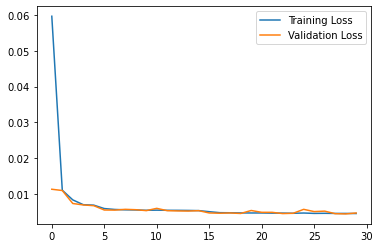

In [15]:
# 120 영업일 기준 모델 학습 양상
plt.plot(history_120.history["loss"], label="Training Loss")
plt.plot(history_120.history["val_loss"], label="Validation Loss")
plt.legend()

In [16]:
# AutoEncoder model - 60 영업일

class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Dense(128, activation="relu"),
          layers.Dense(64, activation="relu"),
          layers.Dense(8, activation="relu")])

        self.decoder = tf.keras.Sequential([
          layers.Dense(64, activation="relu"),
          layers.Dense(128, activation="relu"),
          layers.Dense(60, activation="sigmoid")])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder_60 = AnomalyDetector()

In [17]:
# 60 영업일 기준 모델 학습
autoencoder_60.compile(optimizer='adam', loss='mae')

history_60 = autoencoder_60.fit(train_scaled_60, train_scaled_60,
                                epochs=30,
                                batch_size=16,
                                validation_data=(val_scaled_60, val_scaled_60))

Epoch 1/30
2076/2076 [==============================] - 7s 3ms/step - loss: 0.0877 - val_loss: 0.0077
Epoch 2/30
2076/2076 [==============================] - 6s 3ms/step - loss: 0.0074 - val_loss: 0.0051
Epoch 3/30
2076/2076 [==============================] - 6s 3ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 4/30
2076/2076 [==============================] - 6s 3ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 5/30
2076/2076 [==============================] - 6s 3ms/step - loss: 0.0050 - val_loss: 0.0052
Epoch 6/30
2076/2076 [==============================] - 6s 3ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 7/30
2076/2076 [==============================] - 7s 3ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 8/30
2076/2076 [==============================] - 8s 4ms/step - loss: 0.0049 - val_loss: 0.0051
Epoch 9/30
2076/2076 [==============================] - 6s 3ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 10/30
2076/2076 [==============================] - 6s 3ms/step - loss: 0.004

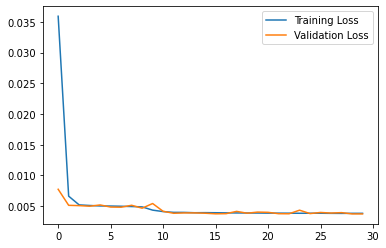

In [18]:
# 60 영업일 기준 모델 학습 양상
plt.plot(history_60.history["loss"], label="Training Loss")
plt.plot(history_60.history["val_loss"], label="Validation Loss")
plt.legend()

In [19]:
# AutoEncoder model - 20 영업일

class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Dense(128, activation="relu"),
          layers.Dense(64, activation="relu"),
          layers.Dense(8, activation="relu")])

        self.decoder = tf.keras.Sequential([
          layers.Dense(64, activation="relu"),
          layers.Dense(128, activation="relu"),
          layers.Dense(20, activation="sigmoid")])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder_20 = AnomalyDetector()

In [20]:
# 20 영업일 기준 모델 학습
autoencoder_20.compile(optimizer='adam', loss='mae')

history_20 = autoencoder_20.fit(train_scaled_20, train_scaled_20, 
                                epochs=30,
                                batch_size=16,
                                validation_data=(val_scaled_20, val_scaled_20))

Epoch 1/30
2101/2101 [==============================] - 7s 3ms/step - loss: 0.0787 - val_loss: 0.0045
Epoch 2/30
2101/2101 [==============================] - 6s 3ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 3/30
2101/2101 [==============================] - 6s 3ms/step - loss: 0.0045 - val_loss: 0.0050
Epoch 4/30
2101/2101 [==============================] - 7s 3ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 5/30
2101/2101 [==============================] - 6s 3ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 6/30
2101/2101 [==============================] - 6s 3ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 7/30
2101/2101 [==============================] - 6s 3ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 8/30
2101/2101 [==============================] - 6s 3ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 9/30
2101/2101 [==============================] - 5s 3ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 10/30
2101/2101 [==============================] - 6s 3ms/step - loss: 0.002

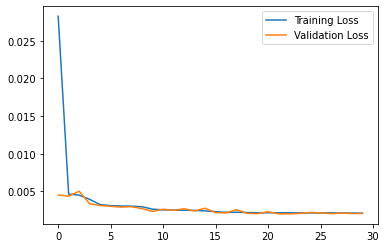

In [21]:
# 20 영업일 기준 모델 학습
plt.plot(history_20.history["loss"], label="Training Loss")
plt.plot(history_20.history["val_loss"], label="Validation Loss")
plt.legend()

#### 2-3) 이상치를 제거한 시계열 데이터의 변동 추이 시각화

60 영업일 기준의 데이터셋을 모델링한 결과를 시각화해보면, 오토인코더를 통해 산출된 결과값이 실제값의 흐름에서 크게 벗어나지 않고 잘 따라가는 것을 확인하 수 있다.

실제값 > 결과값인 면적은 초록색으로, 실제값 < 결과값인 면적은 빨간색으로 표시했다. 이는 뒤에서 매수 혹은 매도의 기준으로 활용된다.

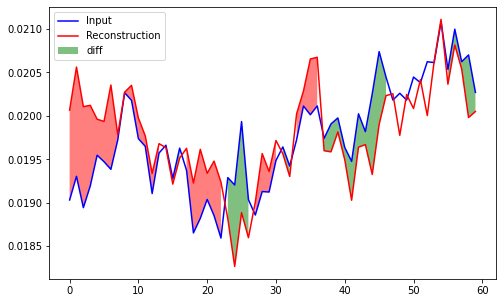

In [22]:
# 60영업일의 train 데이터의 실제 시계열과 AE(오토인코더) 시계열
encoded_imgs_60 = autoencoder_60.encoder(train_scaled_60).numpy()
decoded_imgs_60 = autoencoder_60.decoder(encoded_imgs_60).numpy()

plt.figure(figsize = (8, 5))
plt.plot(train_scaled_60[11000],'b')
plt.plot(decoded_imgs_60[11000],'r')
plt.fill_between(np.arange(60), decoded_imgs_60[11000], train_scaled_60[11000], where=train_scaled_60[11000]>=decoded_imgs_60[11000], facecolor='g', alpha=0.5)
plt.fill_between(np.arange(60), decoded_imgs_60[11000], train_scaled_60[11000], where=train_scaled_60[11000]<decoded_imgs_60[11000], facecolor='r',alpha=0.5)

plt.legend(labels=["Input", "Reconstruction", "diff"])
plt.show()

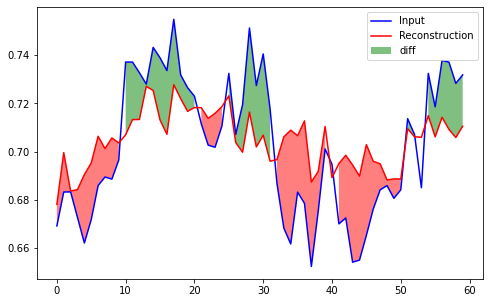

In [23]:
# 60영업일의 val 데이터의 실제 시계열과 AE(오토인코더) 시계열
encoded_imgs_60 = autoencoder_60.encoder(val_scaled_60).numpy()
decoded_imgs_60 = autoencoder_60.decoder(encoded_imgs_60).numpy()

plt.figure(figsize = (8, 5))
plt.plot(val_scaled_60[11000],'b')
plt.plot(decoded_imgs_60[11000],'r')
plt.fill_between(np.arange(60), decoded_imgs_60[11000], val_scaled_60[11000], where=val_scaled_60[11000]>=decoded_imgs_60[11000], facecolor='g', alpha=0.5)
plt.fill_between(np.arange(60), decoded_imgs_60[11000], val_scaled_60[11000], where=val_scaled_60[11000]<decoded_imgs_60[11000], facecolor='r',alpha=0.5)

plt.legend(labels=["Input", "Reconstruction", "diff"])
plt.show()

In [24]:
# test데이터 scaling하기

for i in range(0, len(nh_etf_stock_code)):
    globals()["{}_test_scaled_120".format(nh_etf_stock[i])] = scaler_120.transform(globals()["{}_test_120".format(nh_etf_stock[i])])
    globals()["{}_test_scaled_60".format(nh_etf_stock[i])] = scaler_60.transform(globals()["{}_test_60".format(nh_etf_stock[i])])
    globals()["{}_test_scaled_20".format(nh_etf_stock[i])] = scaler_20.transform(globals()["{}_test_20".format(nh_etf_stock[i])])

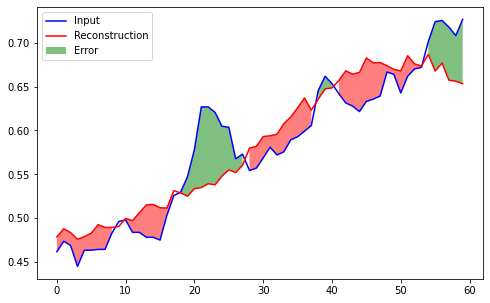

In [25]:
# 60영업일 test 데이터(카카오)의 실제 시계열과 AE 시계열 - 1
encoded_imgs_60 = autoencoder_60.encoder(카카오_test_scaled_60).numpy()
decoded_imgs_60 = autoencoder_60.decoder(encoded_imgs_60).numpy()

plt.figure(figsize = (8, 5))
plt.plot(카카오_test_scaled_60[900],'b')
plt.plot(decoded_imgs_60[900],'r')
plt.fill_between(np.arange(60), decoded_imgs_60[900], 카카오_test_scaled_60[900], where=카카오_test_scaled_60[900]>=decoded_imgs_60[900], facecolor='g', alpha=0.5)
plt.fill_between(np.arange(60), decoded_imgs_60[900], 카카오_test_scaled_60[900], where=카카오_test_scaled_60[900]<decoded_imgs_60[900], facecolor='r',alpha=0.5)

plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

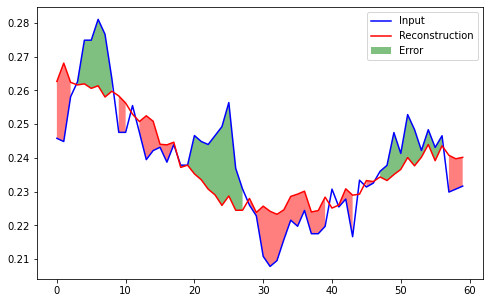

In [26]:
# 60영업일 test 데이터(카카오)의 실제 시계열과 AE 시계열 - 2 

encoded_imgs_60 = autoencoder_60.encoder(카카오_test_scaled_60).numpy()
decoded_imgs_60 = autoencoder_60.decoder(encoded_imgs_60).numpy()

plt.figure(figsize = (8, 5))
plt.plot(카카오_test_scaled_60[300],'b')
plt.plot(decoded_imgs_60[300],'r')
plt.fill_between(np.arange(60), decoded_imgs_60[300], 카카오_test_scaled_60[300], where=카카오_test_scaled_60[300]>=decoded_imgs_60[300], facecolor='g', alpha=0.5)
plt.fill_between(np.arange(60), decoded_imgs_60[300], 카카오_test_scaled_60[300], where=카카오_test_scaled_60[300]<decoded_imgs_60[300], facecolor='r',alpha=0.5)

plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

## 3. 매수·매도 시점 예측

실제 시계열과 오토인코더 시계열 데이터를 시각화한 그래프에서 'diff'라고 표기된 부분의 총 면적값(= 실제값 - 결과값)을 구한다.

면적값이 양수인 경우 1, 음수인 경우 0으로 표시해 각각 매수, 매도 시그널로 판단한다.

In [60]:
# 각 N 영업일 시계열 그래프의 면적 (실제 그래프 면적 - 예측 그래프 면적)
def area(real, pred):
    
    # 실제 그래프 면적
    real_area_list = []
    for data in range(0, len(real)):
        real_area = 0
        for i in range(0, len(real[data]) - 1):
            real_area = real_area + ((real[data][i] + real[data][i+1]) / 2)

        real_area_list.append(real_area)

    # 예측 그래프 면적
    pred_area_list = []
    for data in range(0, len(pred)):
        pred_area = 0
        for j in range(0, len(pred[data]) - 1):
            pred_area = pred_area + ((pred[data][i] + pred[data][i+1]) / 2)

        pred_area_list.append(pred_area)

    real_minus_pred = np.array(real_area_list) - np.array(pred_area_list)

    return real_minus_pred

In [61]:
# 매수·매도 시그널 표시 : 총 면적값이 양수면 1(=매수), 음수면 0(=매도)으로 표기
def signal(data):
    signal_list = []
    for i in range(0, len(data)):
        if data[i] > 0:
            signal_list.append(1)
            
        else:
            signal_list.append(0)
            
    return signal_list

In [62]:
# 각 종목 별 면적에 따른 signal
def investment_signal(nh_etf_stock_code, nh_etf_stock, autoencoder, n):
    signal_df = pd.DataFrame(columns = ["date"])
    
    for i in range(0, len(nh_etf_stock_code)):
        encoded_imgs = autoencoder.encoder(globals()["{}_test_scaled_{}".format(nh_etf_stock[i], n)]).numpy()
        decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
        
        signal_list = signal(area(globals()["{}_test_scaled_{}".format(nh_etf_stock[i], n)], decoded_imgs))
        test_date = globals()["{}_test_date_{}".format(nh_etf_stock[i], n)]
        
        # 개별 종목 signal
        ind_df = pd.DataFrame()
        ind_df["date"] = test_date
        ind_df[nh_etf_stock[i]] = signal_list
        
        # merge
        signal_df = pd.merge(signal_df, ind_df, on = "date", how = "outer")

        # 결측치 0으로 대체 (결측치 존재하는 시기는 상장되지 않은 시기)
        signal_df = signal_df.fillna(0)
        
    return signal_df

In [63]:
signal_df_120 = investment_signal(nh_etf_stock_code, nh_etf_stock, autoencoder_120, 120)
signal_df_60 = investment_signal(nh_etf_stock_code, nh_etf_stock, autoencoder_60, 60)
signal_df_20 = investment_signal(nh_etf_stock_code, nh_etf_stock, autoencoder_20, 20)

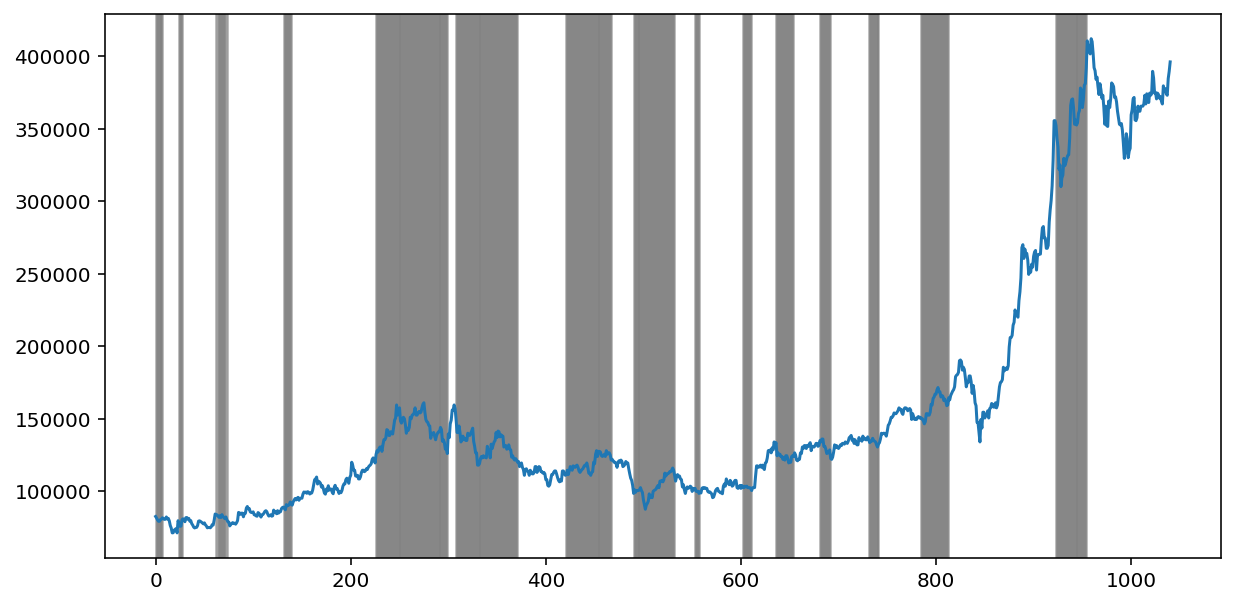

In [64]:
# 카카오 매수 매도 시점 시각화 (60영업일 기준)
plt.figure(figsize = (10, 5))

plt.plot(카카오_test_60["close"])

for time in range(0, len(signal_df_60["카카오"]) - 1):
    if signal_df_60["카카오"][time] == 1:
        plt.axvspan(time, time + 1, color = "gray", alpha = 0.5)
        
plt.show()

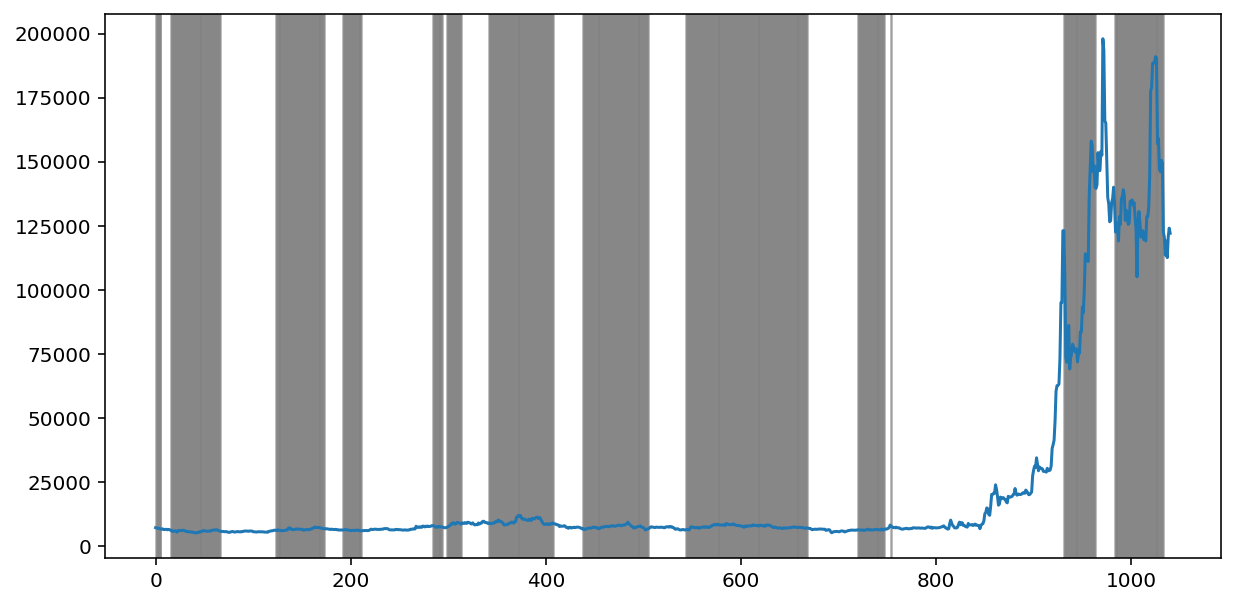

In [65]:
# 신풍제약 매수 매도 시점 시각화 (60영업일 기준)
plt.figure(figsize = (10, 5))

plt.plot(신풍제약_test_60["close"])

for time in range(0, len(signal_df_60["신풍제약"]) - 1):
    if signal_df_60["신풍제약"][time] == 1:
        plt.axvspan(time, time + 1, color = "gray", alpha = 0.5)
        
plt.show()

## 4. 포트폴리오 구성

- test데이터 기간 동안의 각 종목 별 비중을 구해, 같은 날짜에 signal이 1인 종목들을 동일한 비중으로 투자한다.

    ex) 만약 2017-01-02에 총 20가지 종목 중 signal이 1인 종목이 두가지라면, 각 50%씩 가중을 두어 투자한다. 


- 벤치마크(=설계한 포트폴리오의 결과와 비교 및 평가하기 위한 기준이 되는 포트폴리오) 포트폴리오는 다음과 같이 설정했다.<BR>
1) 동일가중 포트폴리오 : 같은 기간동안 매일 동일 가중으로 투자하도록 설정한 포트폴리오<BR>
2) 장기보유 포트폴리오 : 처음 매수 시점 동일 가중으로 투자하고 그 이후에는 별다른 비중 조정 없이 보유만 하는 포트폴리오

#### 4-1) 오토인코더 기반 포트폴리오의 수익률 산출

In [66]:
# test데이터 기간의 각 종목별 비중 
def weight(signal_df):
    weight = pd.DataFrame(columns = signal_df.columns[1:])
    
    for i in range(0, len(signal_df)):
    
        # 모든 종목 signal이 0인 경우
        if sum(list(signal_df.iloc[:,1:].loc[i])) == 0:
            weight.loc[i] = np.zeros(20)

        # 모든 종목 singal 중 1이 1개 이상 있는 경우 - 1인 종목들에 동일 가중 투자
        else:
            equal_weighted = 1 / sum(list(signal_df.iloc[:,1:].loc[i]))

            weight_list = []
            for j in range(0, len(list(signal_df.iloc[:,1:].loc[i]))):

                if list(signal_df.iloc[:,1:].loc[i])[j] == 0:
                    weight_list.append(0)

                else:
                    weight_list.append(equal_weighted)

            weight.loc[i] = weight_list

    weight.insert(0, "date", signal_df["date"])
    
    return weight

In [67]:
weight_120 = weight(signal_df_120)
weight_60 = weight(signal_df_60)
weight_20 = weight(signal_df_20)

In [71]:
# 60일은 영업기준일로 둔 포트폴리오의 경우, 2017-01-02에 signal이 1인 종목은 총 10개, 이 종목들에 각 0.090909%씩 동일 가중으로 투자
# 영업기준일을 얼마로 두냐에 따라 가중 투자할 종목이 달라진다.
weight_60.loc[0]

date          2017-01-02 00:00:00
카카오                      0.090909
NAVER                    0.090909
삼성SDI                         0.0
엔씨소프트                    0.090909
LG화학                          0.0
셀트리온                     0.090909
삼성바이오로직스                      0.0
셀트리온헬스케어                      0.0
SK이노베이션                  0.090909
포스코케미칼                        0.0
넷마블                           0.0
신풍제약                     0.090909
펄어비스                          0.0
SK바이오팜                        0.0
더존비즈온                    0.090909
케이엠더블유                   0.090909
에코프로비엠                        0.0
컴투스                      0.090909
NHN한국사이버결제               0.090909
NHN                      0.090909
Name: 0, dtype: object

In [70]:
# 2017-01-02에 signal이 1인 종목은 총 10개지만 60일 영업기준일의 포트폴리오와 구성 종목은 다르다.
weight_120.loc[0]

date          2017-01-02 00:00:00
카카오                      0.090909
NAVER                    0.090909
삼성SDI                    0.090909
엔씨소프트                    0.090909
LG화학                          0.0
셀트리온                     0.090909
삼성바이오로직스                      0.0
셀트리온헬스케어                      0.0
SK이노베이션                  0.090909
포스코케미칼                        0.0
넷마블                           0.0
신풍제약                     0.090909
펄어비스                          0.0
SK바이오팜                        0.0
더존비즈온                    0.090909
케이엠더블유                        0.0
에코프로비엠                        0.0
컴투스                      0.090909
NHN한국사이버결제               0.090909
NHN                      0.090909
Name: 0, dtype: object

In [72]:
# 일별 수익률 불러오는 함수
def price_return(code, test_start_date, test_end_date):
    stock = fdr.DataReader(code, test_start_date, test_end_date)
    stock = stock.reset_index()
    stock.columns = ["date", "open", "high", "low", "close", "volume", "change"]
    stock = stock[["date", "change"]]
    
    stock["change(t+1)"] = stock["change"].shift(1)
    stock = stock[["date", "change(t+1)"]]
    
    stock = stock.dropna().reset_index(drop = True)
    
    return stock

In [73]:
# 각 종목 별 테스트 기간의 일별 수익률 
def daily_return_per_stock(nh_etf_stock_code, nh_etf_stock, weight):
    test_return = pd.DataFrame(columns = ["date"])

    for i in range(0, len(nh_etf_stock_code)):
        globals()["{}_test_return".format(nh_etf_stock[i])] = price_return(nh_etf_stock_code[i], "2016-12-29", list(weight["date"])[-1])
        globals()["{}_test_return".format(nh_etf_stock[i])].columns = ["date", nh_etf_stock[i]]

        test_return = pd.merge(test_return, globals()["{}_test_return".format(nh_etf_stock[i])], on = "date", how = "outer")

    test_return = test_return.fillna(0)
    
    return test_return

In [74]:
test_return_120 = daily_return_per_stock(nh_etf_stock_code, nh_etf_stock, weight_120)
test_return_60 = daily_return_per_stock(nh_etf_stock_code, nh_etf_stock, weight_60)
test_return_20 = daily_return_per_stock(nh_etf_stock_code, nh_etf_stock, weight_20)

In [75]:
# 60 영업일 기준
test_return_60.head(3)

,date,카카오,NAVER,삼성SDI,엔씨소프트,LG화학,셀트리온,삼성바이오로직스,셀트리온헬스케어,SK이노베이션,...,넷마블,신풍제약,펄어비스,SK바이오팜,더존비즈온,케이엠더블유,에코프로비엠,컴투스,NHN한국사이버결제,NHN
0,2017-01-02,0.019868,0.015725,0.013953,0.008147,0.000000,0.008446,-0.006579,0.0,-0.010135,...,0.0,0.006768,0.0,0.0,0.016588,0.024660,0.0,-0.005701,0.000000,-0.003960
1,2017-01-03,-0.003896,0.002583,-0.027523,0.002020,-0.030651,0.007445,0.036424,0.0,0.003413,...,0.0,0.023529,0.0,0.0,-0.011655,0.042600,0.0,0.043578,-0.027210,0.005964
2,2017-01-04,0.043025,-0.012871,0.037736,0.044355,0.035573,-0.014780,0.009585,0.0,0.054422,...,0.0,0.001642,0.0,0.0,-0.007075,0.025736,0.0,0.054945,0.056139,0.000000


위의 데이터프레임은 각 종목의 일별 수익률을 나타낸 것이다.

예를 들어, '카카오' 컬럼의 첫번째 행은 2017년 1월 2일 종가에 매수하여 2017년 1월 3일에 매도했을 때의 수익률이다.<BR>
또한, 두번째 행은 2017년 1월 3일 종가에 매수하여 2017년 1월 4일에 매도했을 때의 수익률이다.

In [76]:
# 비용을 포함한 전체 일별 수익률 산출
# (매매수수료 각 0.015%, 증권거래세 코스피는 0.08%, 코스닥은 0.23%)
def autoencoder_strategy(weight, test_return):
    adj_return_list = []
    for i in range(0, len(weight)):

        # 비용 차감
        if i == 0:
            for col in weight.columns[1:]:
                globals()["{}_adj_return".format(col)] = weight[col][i] * (test_return[col][i] - 0.00015)

        else:
            for col in weight.columns[1:]:

                # 매수 시의 비용
                if weight[col][i] - weight[col][i-1] >= 0:
                    globals()["{}_adj_return".format(col)] = weight[col][i] * test_return[col][i] - (abs(weight[col][i] - weight[col][i-1]) * 0.00015)

                # 매도 시의 비용
                else:
                    # 코스닥 종목인 경우
                    if (col == "셀트리온헬스케어") or (col == "펄어비스") or (col == "케이엠더블유") or (col == "에코프로비엠") or (col == "컴투스") or (col == "NHN한국사이버결제"):
                        globals()["{}_adj_return".format(col)] = weight[col][i] * test_return[col][i] - (abs(weight[col][i] - weight[col][i-1]) * 0.00245)

                    # 코스피 종목인 경우
                    else:
                        globals()["{}_adj_return".format(col)] = weight[col][i] * test_return[col][i] - (abs(weight[col][i] - weight[col][i-1]) * 0.00095)

        # 매 기 별 수익률
        ind_return = 0
        for col in weight.columns[1:]:
            ind_return = ind_return + globals()["{}_adj_return".format(col)]

        adj_return_list.append(ind_return)

    test_return["daily_return"] = adj_return_list
    
    return test_return

In [77]:
test_return_120 = autoencoder_strategy(weight_120, test_return_120)
test_return_60 = autoencoder_strategy(weight_60, test_return_60)
test_return_20 = autoencoder_strategy(weight_20, test_return_20)

In [43]:
test_return_60.head(3)

,date,카카오,NAVER,삼성SDI,엔씨소프트,LG화학,셀트리온,삼성바이오로직스,셀트리온헬스케어,SK이노베이션,...,신풍제약,펄어비스,SK바이오팜,더존비즈온,케이엠더블유,에코프로비엠,컴투스,NHN한국사이버결제,NHN,daily_return
0,2017-01-02,0.019868,0.015725,0.013953,0.008147,0.000000,0.008446,-0.006579,0.0,-0.010135,...,0.006768,0.0,0.0,0.016588,0.024660,0.0,-0.005701,0.000000,-0.003960,0.007159
1,2017-01-03,-0.003896,0.002583,-0.027523,0.002020,-0.030651,0.007445,0.036424,0.0,0.003413,...,0.023529,0.0,0.0,-0.011655,0.042600,0.0,0.043578,-0.027210,0.005964,0.007993
2,2017-01-04,0.043025,-0.012871,0.037736,0.044355,0.035573,-0.014780,0.009585,0.0,0.054422,...,0.001642,0.0,0.0,-0.007075,0.025736,0.0,0.054945,0.056139,0.000000,0.026032


- 'daily_return'은 포트폴리오 시나리오에 따라 signal이 1인 종목들만 동일한 가중으로 투자했을 때의 일별 수익률이다.

- 매매수수료는 매수, 매도 둘다 0.015%를 부과하는데 매도할 경우엔 거기에 증권거래세가 붙는다.

  증권거래세란 가지고 있는 주식을 팔 때 판 가격에 부과되는 세금이며 코스피 종목은 0.08%, 코스닥 종목은 0.23%가 부과된다.

  즉 코스피 종목을 매도 시 부과되는 총 세금 비율은 `0.015% + 0.08% = 0.095%`, 코스피 종목 매도 시 `0.015% + 0.23% = 0.245%` 

In [78]:
# 누적 수익률
def cumulative_return(test_return):
    new_asset = 1
    cum_return = []
    asset_value = []

    for i in range(0, len(test_return)):
        daily_return = test_return["daily_return"][i] + 1
        new_asset = new_asset * daily_return
        cum_r = (new_asset - 1) * 100

        cum_return.append(cum_r)
        asset_value.append(new_asset)

    test_return["cum_return(%)"] = cum_return
    test_return["asset_value"] = asset_value
    
    return test_return

In [79]:
test_return_120 = cumulative_return(test_return_120)
test_return_60 = cumulative_return(test_return_60)
test_return_20 = cumulative_return(test_return_20)

In [80]:
# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

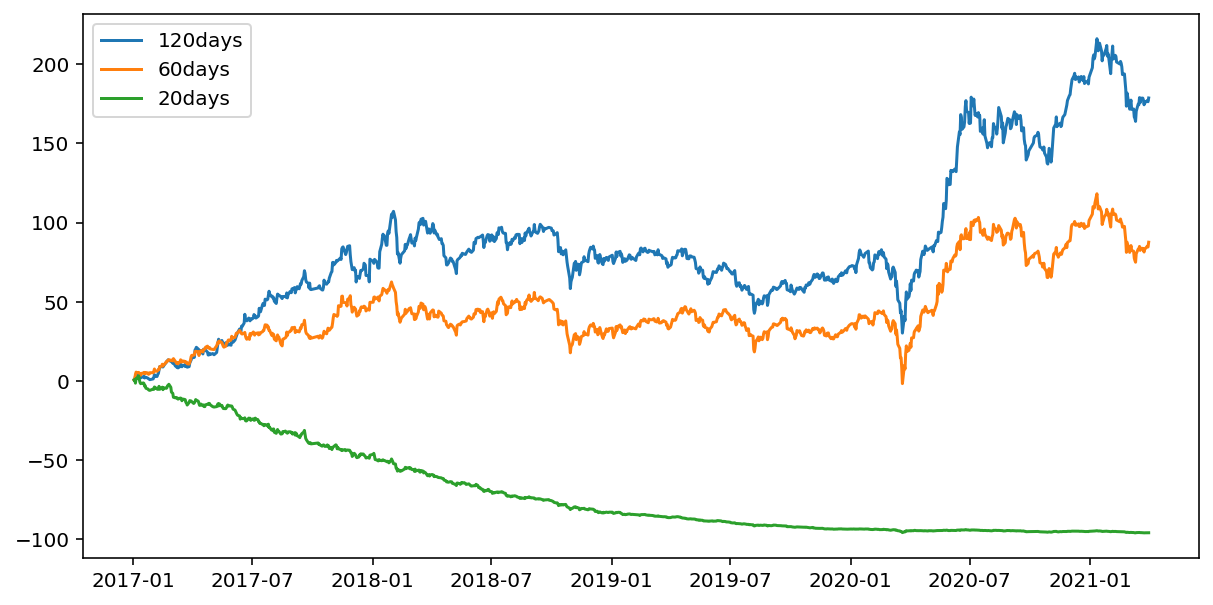

In [81]:
# 매 영업일(120, 60, 20)에 따른 누적 수익률 시각화 => 매 영업일마다 시계열 길이가 다르기 때문에 조정
standard_test_return_60 = test_return_60[test_return_60["date"] <= list(test_return_120["date"])[-1]]
standard_test_return_20 = test_return_20[test_return_20["date"] <= list(test_return_120["date"])[-1]]

plt.figure(figsize = (10, 5))

plt.plot(test_return_120["date"], test_return_120["cum_return(%)"], label = "120days")
plt.plot(standard_test_return_60["date"], standard_test_return_60["cum_return(%)"], label = "60days")
plt.plot(standard_test_return_20["date"], standard_test_return_20["cum_return(%)"], label = "20days")

plt.legend()

plt.show()

- 포트폴리오 기반으로 투자했을 때, 120 영업일 기준으로 모델링 할 때 수익률이 가장 높고, 20 영업일 기준의 수익률은 마이너로 감소한다.
- 4년간의 수익률을 살펴보면, 120 영업일 기준일 때 수익률은 200% 가까이 올랐고, 60 영업일 기준일 때는 100% 정도 올랐다.

#### 4-2) 벤치마크 1 - 동일가중 투자 전략 구현

In [82]:
# 벤치마크 (20 종목에 동일 가중으로 투자한 포트폴리오) 비중 -> 4-1)의 weight 함수와 대비
equal_weighted = pd.DataFrame()
equal_weighted["date"] = weight_60["date"]

for col in weight_60.columns[1:]:
    equal_weighted[col] = 1 / 20
    
equal_weighted.head(3)

,date,카카오,NAVER,삼성SDI,엔씨소프트,LG화학,셀트리온,삼성바이오로직스,셀트리온헬스케어,SK이노베이션,...,넷마블,신풍제약,펄어비스,SK바이오팜,더존비즈온,케이엠더블유,에코프로비엠,컴투스,NHN한국사이버결제,NHN
0,2017-01-02,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
1,2017-01-03,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
2,2017-01-04,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05


In [83]:
# 각 종목 별 테스트 기간의 일별 수익률 산출
equal_test_return = pd.DataFrame(columns = ["date"])

for i in range(0, len(nh_etf_stock_code)):
    globals()["{}_equal_test_return".format(nh_etf_stock[i])] = price_return(nh_etf_stock_code[i], "2016-12-29", list(weight_60["date"])[-1])
    globals()["{}_equal_test_return".format(nh_etf_stock[i])].columns = ["date", nh_etf_stock[i]]
    
    equal_test_return = pd.merge(equal_test_return, globals()["{}_equal_test_return".format(nh_etf_stock[i])], on = "date", how = "outer")
    
equal_test_return = equal_test_return.fillna(0)

equal_test_return.head(3)

,date,카카오,NAVER,삼성SDI,엔씨소프트,LG화학,셀트리온,삼성바이오로직스,셀트리온헬스케어,SK이노베이션,...,넷마블,신풍제약,펄어비스,SK바이오팜,더존비즈온,케이엠더블유,에코프로비엠,컴투스,NHN한국사이버결제,NHN
0,2017-01-02,0.019868,0.015725,0.013953,0.008147,0.000000,0.008446,-0.006579,0.0,-0.010135,...,0.0,0.006768,0.0,0.0,0.016588,0.024660,0.0,-0.005701,0.000000,-0.003960
1,2017-01-03,-0.003896,0.002583,-0.027523,0.002020,-0.030651,0.007445,0.036424,0.0,0.003413,...,0.0,0.023529,0.0,0.0,-0.011655,0.042600,0.0,0.043578,-0.027210,0.005964
2,2017-01-04,0.043025,-0.012871,0.037736,0.044355,0.035573,-0.014780,0.009585,0.0,0.054422,...,0.0,0.001642,0.0,0.0,-0.007075,0.025736,0.0,0.054945,0.056139,0.000000


In [84]:
# 동일 가중 포트폴리오의 매 기 별 수익률 산출

equal_daily_return_list = []
for i in range(0, len(equal_weighted)):
    
    daily_return = 0
    for j in range(0, len(nh_etf_stock)):
        daily_return = daily_return + equal_weighted[nh_etf_stock[j]][i] * equal_test_return[nh_etf_stock[j]][i]
    
    equal_daily_return_list.append(daily_return)
    
equal_test_return["daily_return"] = equal_daily_return_list

equal_test_return.head(3)

,date,카카오,NAVER,삼성SDI,엔씨소프트,LG화학,셀트리온,삼성바이오로직스,셀트리온헬스케어,SK이노베이션,...,신풍제약,펄어비스,SK바이오팜,더존비즈온,케이엠더블유,에코프로비엠,컴투스,NHN한국사이버결제,NHN,daily_return
0,2017-01-02,0.019868,0.015725,0.013953,0.008147,0.000000,0.008446,-0.006579,0.0,-0.010135,...,0.006768,0.0,0.0,0.016588,0.024660,0.0,-0.005701,0.000000,-0.003960,0.003569
1,2017-01-03,-0.003896,0.002583,-0.027523,0.002020,-0.030651,0.007445,0.036424,0.0,0.003413,...,0.023529,0.0,0.0,-0.011655,0.042600,0.0,0.043578,-0.027210,0.005964,0.003331
2,2017-01-04,0.043025,-0.012871,0.037736,0.044355,0.035573,-0.014780,0.009585,0.0,0.054422,...,0.001642,0.0,0.0,-0.007075,0.025736,0.0,0.054945,0.056139,0.000000,0.015380


In [85]:
# 누적 포트폴리오 수익률
new_asset = 1
cum_return = []
asset_value = []

for i in range(0, len(equal_test_return)):
    daily_return = equal_test_return["daily_return"][i] + 1
    new_asset = new_asset * daily_return
    cum_r = (new_asset - 1) * 100
    
    cum_return.append(cum_r)
    asset_value.append(new_asset)

equal_test_return["cum_return(%)"] = cum_return
equal_test_return["asset_value"] = asset_value

equal_test_return.head()

,date,카카오,NAVER,삼성SDI,엔씨소프트,LG화학,셀트리온,삼성바이오로직스,셀트리온헬스케어,SK이노베이션,...,SK바이오팜,더존비즈온,케이엠더블유,에코프로비엠,컴투스,NHN한국사이버결제,NHN,daily_return,cum_return(%),asset_value
0,2017-01-02,0.019868,0.015725,0.013953,0.008147,0.000000,0.008446,-0.006579,0.0,-0.010135,...,0.0,0.016588,0.024660,0.0,-0.005701,0.000000,-0.003960,0.003569,0.356926,1.003569
1,2017-01-03,-0.003896,0.002583,-0.027523,0.002020,-0.030651,0.007445,0.036424,0.0,0.003413,...,0.0,-0.011655,0.042600,0.0,0.043578,-0.027210,0.005964,0.003331,0.691223,1.006912
2,2017-01-04,0.043025,-0.012871,0.037736,0.044355,0.035573,-0.014780,0.009585,0.0,0.054422,...,0.0,-0.007075,0.025736,0.0,0.054945,0.056139,0.000000,0.015380,2.239843,1.022398
3,2017-01-05,0.053750,0.056061,-0.013636,0.003861,0.024809,-0.004698,-0.022152,0.0,0.006452,...,0.0,0.026128,0.006208,0.0,0.003125,-0.026670,0.015810,0.007614,3.018287,1.030183
4,2017-01-06,-0.003559,-0.023454,0.032258,0.003846,-0.003724,0.002836,0.019417,0.0,-0.012821,...,0.0,-0.011574,-0.001285,0.0,-0.021807,0.019668,-0.015564,0.000532,3.073089,1.030731


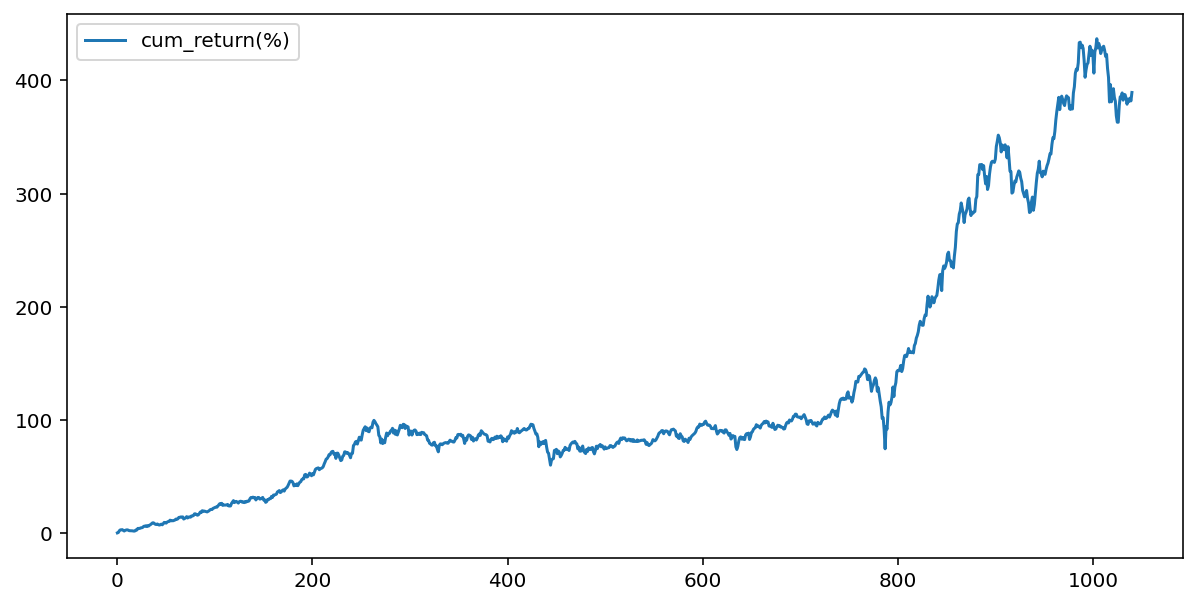

In [90]:
# 동일가중 투자 전략 시 누적 수익률 시각화
plt.figure(figsize = (10, 5))

plt.plot(equal_test_return["cum_return(%)"], label='cum_return(%)')
plt.legend()
plt.show()

#### 4-3) 벤치마크 2 - 동일 가중으로 투자한 뒤 장기 보유 전략 구현

맨 처음에 모든 종목을 동일 가중으로 투자한 뒤, 2021-03-31까지 한번도 매수·매도 하지 않았을 때 수익률 산출

In [91]:
# 각 종목 별 테스트 기간의 일별 수익률 불러오기
hold_test_return = pd.DataFrame(columns = ["date"])

for i in range(0, len(nh_etf_stock_code)):
    globals()["{}_hold_test_return".format(nh_etf_stock[i])] = price_return(nh_etf_stock_code[i], "2016-12-29", list(weight_60["date"])[-1])
    globals()["{}_hold_test_return".format(nh_etf_stock[i])].columns = ["date", nh_etf_stock[i]]
    
    hold_test_return = pd.merge(hold_test_return, globals()["{}_hold_test_return".format(nh_etf_stock[i])], on = "date", how = "outer")
    
hold_test_return = hold_test_return.fillna(0)

hold_test_return.head(3)

,date,카카오,NAVER,삼성SDI,엔씨소프트,LG화학,셀트리온,삼성바이오로직스,셀트리온헬스케어,SK이노베이션,...,넷마블,신풍제약,펄어비스,SK바이오팜,더존비즈온,케이엠더블유,에코프로비엠,컴투스,NHN한국사이버결제,NHN
0,2017-01-02,0.019868,0.015725,0.013953,0.008147,0.000000,0.008446,-0.006579,0.0,-0.010135,...,0.0,0.006768,0.0,0.0,0.016588,0.024660,0.0,-0.005701,0.000000,-0.003960
1,2017-01-03,-0.003896,0.002583,-0.027523,0.002020,-0.030651,0.007445,0.036424,0.0,0.003413,...,0.0,0.023529,0.0,0.0,-0.011655,0.042600,0.0,0.043578,-0.027210,0.005964
2,2017-01-04,0.043025,-0.012871,0.037736,0.044355,0.035573,-0.014780,0.009585,0.0,0.054422,...,0.0,0.001642,0.0,0.0,-0.007075,0.025736,0.0,0.054945,0.056139,0.000000


In [92]:
# 각 종목 별 누적 수익률
cum_return_df = pd.DataFrame()
asset_value_df = pd.DataFrame()

cum_return_df["date"] = hold_test_return["date"]
asset_value_df["date"] = hold_test_return["date"]

for col in nh_etf_stock:
    ind_df = hold_test_return[["date", col]]
    
    new_asset = 1
    cum_return = []
    asset_value = []

    for i in range(0, len(ind_df)):
        daily_return = ind_df[col][i] + 1
        new_asset = new_asset * daily_return
        cum_r = (new_asset - 1) * 100

        cum_return.append(cum_r)
        asset_value.append(new_asset)

    cum_return_df[col] = cum_return
    asset_value_df[col] = asset_value

# 동일 가중으로 투자한 뒤 장기 보유 전략 누적 수익률
hold_test_return["cum_return(%)"] = cum_return_df.iloc[:,1:].sum(axis = 1) / 20
hold_test_return["asset_value"] = asset_value_df.iloc[:,1:].sum(axis = 1) / 20
hold_test_return.head()

,date,카카오,NAVER,삼성SDI,엔씨소프트,LG화학,셀트리온,삼성바이오로직스,셀트리온헬스케어,SK이노베이션,...,펄어비스,SK바이오팜,더존비즈온,케이엠더블유,에코프로비엠,컴투스,NHN한국사이버결제,NHN,cum_return(%),asset_value
0,2017-01-02,0.019868,0.015725,0.013953,0.008147,0.000000,0.008446,-0.006579,0.0,-0.010135,...,0.0,0.0,0.016588,0.024660,0.0,-0.005701,0.000000,-0.003960,0.356926,1.003569
1,2017-01-03,-0.003896,0.002583,-0.027523,0.002020,-0.030651,0.007445,0.036424,0.0,0.003413,...,0.0,0.0,-0.011655,0.042600,0.0,0.043578,-0.027210,0.005964,0.690677,1.006907
2,2017-01-04,0.043025,-0.012871,0.037736,0.044355,0.035573,-0.014780,0.009585,0.0,0.054422,...,0.0,0.0,-0.007075,0.025736,0.0,0.054945,0.056139,0.000000,2.236759,1.022368
3,2017-01-05,0.053750,0.056061,-0.013636,0.003861,0.024809,-0.004698,-0.022152,0.0,0.006452,...,0.0,0.0,0.026128,0.006208,0.0,0.003125,-0.026670,0.015810,3.006818,1.030068
4,2017-01-06,-0.003559,-0.023454,0.032258,0.003846,-0.003724,0.002836,0.019417,0.0,-0.012821,...,0.0,0.0,-0.011574,-0.001285,0.0,-0.021807,0.019668,-0.015564,3.040138,1.030401


In [93]:
# daily return 구하기 (volatility와 sharp ratio 산출을 위해)
hold_daily_return = []

for i in range(0, len(hold_test_return) - 1):
    daily_return = (1 + (hold_test_return["cum_return(%)"][i+1] * 0.01)) / (1 + (hold_test_return["cum_return(%)"][i] * 0.01))
    hold_daily_return.append(daily_return - 1)
    
hold_daily_return.insert(0, hold_test_return["cum_return(%)"][0] * 0.01)
hold_test_return["daily_return"] = hold_daily_return
hold_test_return.head()

,date,카카오,NAVER,삼성SDI,엔씨소프트,LG화학,셀트리온,삼성바이오로직스,셀트리온헬스케어,SK이노베이션,...,SK바이오팜,더존비즈온,케이엠더블유,에코프로비엠,컴투스,NHN한국사이버결제,NHN,cum_return(%),asset_value,daily_return
0,2017-01-02,0.019868,0.015725,0.013953,0.008147,0.000000,0.008446,-0.006579,0.0,-0.010135,...,0.0,0.016588,0.024660,0.0,-0.005701,0.000000,-0.003960,0.356926,1.003569,0.003569
1,2017-01-03,-0.003896,0.002583,-0.027523,0.002020,-0.030651,0.007445,0.036424,0.0,0.003413,...,0.0,-0.011655,0.042600,0.0,0.043578,-0.027210,0.005964,0.690677,1.006907,0.003326
2,2017-01-04,0.043025,-0.012871,0.037736,0.044355,0.035573,-0.014780,0.009585,0.0,0.054422,...,0.0,-0.007075,0.025736,0.0,0.054945,0.056139,0.000000,2.236759,1.022368,0.015355
3,2017-01-05,0.053750,0.056061,-0.013636,0.003861,0.024809,-0.004698,-0.022152,0.0,0.006452,...,0.0,0.026128,0.006208,0.0,0.003125,-0.026670,0.015810,3.006818,1.030068,0.007532
4,2017-01-06,-0.003559,-0.023454,0.032258,0.003846,-0.003724,0.002836,0.019417,0.0,-0.012821,...,0.0,-0.011574,-0.001285,0.0,-0.021807,0.019668,-0.015564,3.040138,1.030401,0.000323


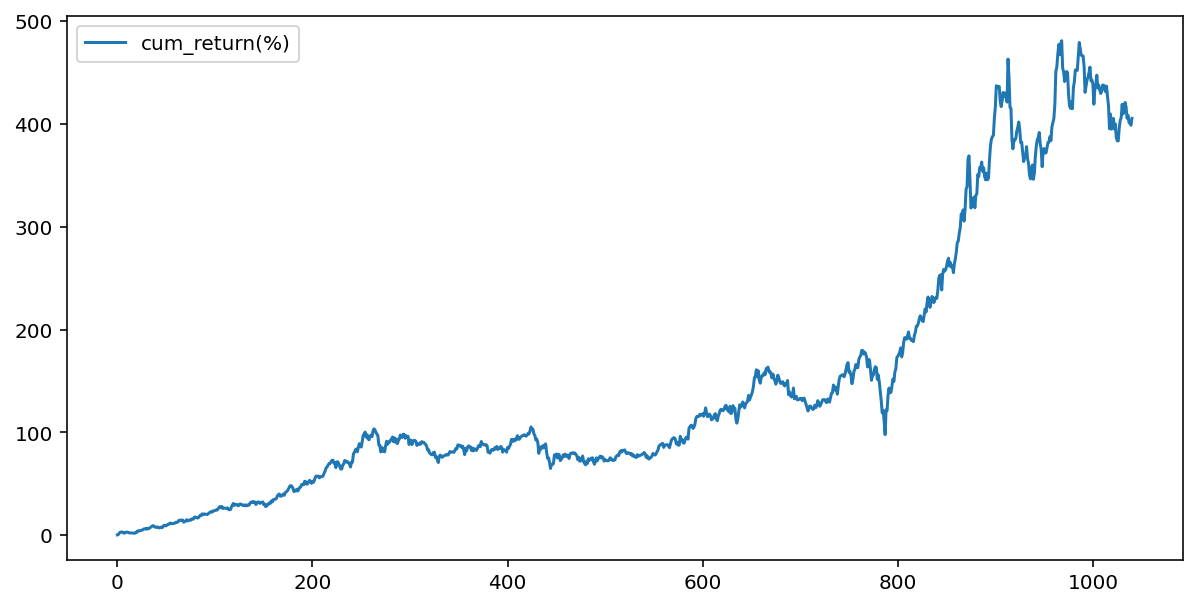

In [94]:
# 동일 가중으로 투자한 뒤 장기 보유 전략 구현 시 수익률 시각화
plt.figure(figsize = (10, 5))

plt.plot(hold_test_return["cum_return(%)"], label='cum_return(%)')
plt.legend()
plt.show()

#### 4-4) 오토인코더 포트폴리오와 벤치마크 비교

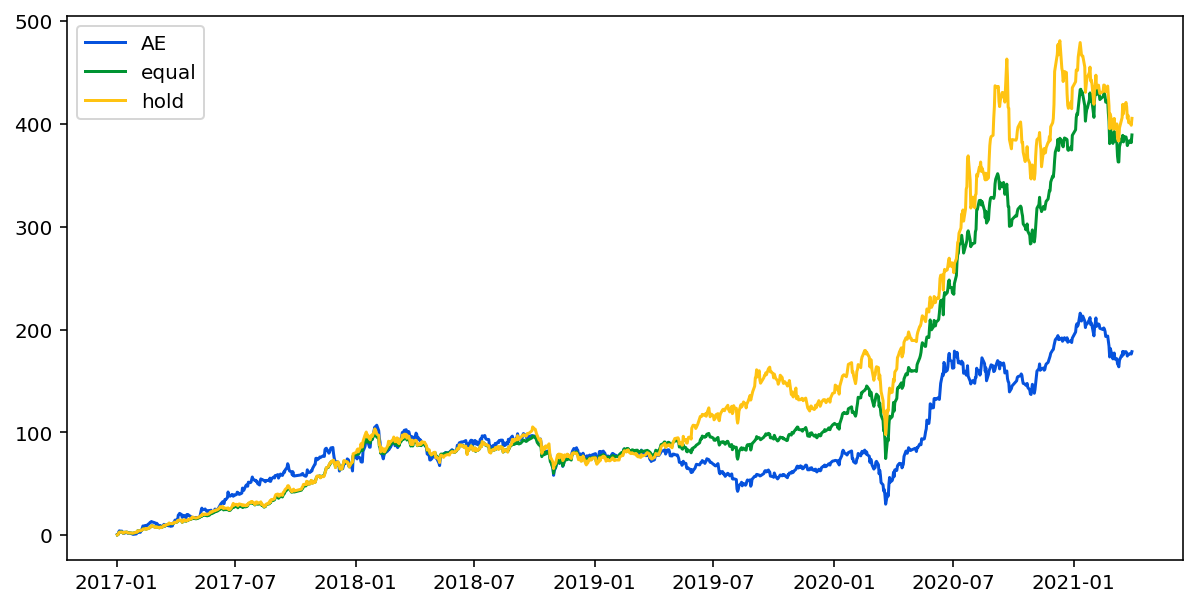

In [110]:
# 누적 수익률 시각화
plt.figure(figsize = (10, 5))

plt.plot(test_return_120["date"], test_return_120["cum_return(%)"], label = "AE", color='#0652DD')
plt.plot(equal_test_return["date"], equal_test_return["cum_return(%)"], label = "equal", color='#009432')
plt.plot(hold_test_return["date"], hold_test_return["cum_return(%)"], label = "hold", color='#FFC312')

plt.legend()

plt.show()

- 오토인코더 포트폴리오는 가장 수익률이 높았던 120 영업일 기준으로 모델링 했을 때의 수익률 데이터를 사용했다.

- 매수매도 시그널을 바탕으로 가중을 조정한 오토인코더 포트폴리오는 동일 가중으로 투자한 나머지 포트폴리오에 비해 수익률이 절반 채 안된다.

- 동일 가중 포트폴리오에서도 초기 1년을 제외하고는 대부분 장기보유전략의 수익률이 가장 높다.

## 5. 성과지표

In [107]:
# 포트폴리오 성과 지표
import numpy as np

def portfolio_report(df):
    pf_report = pd.DataFrame()
    
    # MDD(최대낙폭)
    arr_v = np.array(df["asset_value"])
    peak_lower = np.argmax(np.maximum.accumulate(arr_v) - arr_v)
    peak_upper = np.argmax(arr_v[:peak_lower])
    mdd = (arr_v[peak_lower] - arr_v[peak_upper]) / arr_v[peak_upper]
    
    # CAGR(연평균 성장률)
    diff = df["date"].iloc[-1] - df["date"].iloc[0]
    N = diff.days / 365
    cum = (1 + (df["cum_return(%)"][len(df)-1] * 0.01))
    CAGR = (cum**(1/N)) - 1
    
    # Sharp ratio ((CAGR - rf) / vol_year) : 표준편차 => 약 3년 간의 daily return * sqrt(252)
    std = np.std(df["daily_return"]) * np.sqrt(252)
    rf = 0.03  # 기초수익률?
    SR = (CAGR - rf) / std
    
    pf_report["cum_return"] = [round(df["cum_return(%)"][len(df)-1], 2)]
    pf_report["CAGR"] = round(CAGR * 100, 3)
    pf_report["MDD"] = round(mdd * 100, 3)
    pf_report["SR"] = round(SR, 3) 
    pf_report["Std"] = round(std, 3) # 변동성

    return pf_report

In [109]:
AE_report = portfolio_report(test_return_120).T
equal_report = portfolio_report(equal_test_return).T
hold_report = portfolio_report(hold_test_return).T

all_report = pd.concat([AE_report, equal_report, hold_report], axis = 1)
all_report.columns = ["AE", "equal", "hold"]
all_report

,AE,equal,hold
cum_return,178.580,389.350,405.490
CAGR,27.306,45.378,46.494
MDD,-37.100,-13.747,-20.766
SR,0.945,1.916,1.643
Std,0.257,0.221,0.265


* cum_return : 누적수익률
* CAGR : 연평균수익률
* MDD : 최대 낙 폭
* SR(샤프비율) : 위험 대비 수익률
* Std : 변동성

- 수익률 측면에서는 장기보유 포트폴리오가 우수했으며, 안정성 측면에서는 동일가중 포트폴리오가 우수했다.<BR>
- 상대적으로 AE 포트폴리오는 모든 측면에서 좋은 성과를 보이지 못했다.<BR>
- 추가적으로 가격 데이터 외의 데이터를 활용하고, 더 많은 종목들로 학습을 진행하며, 매수 및 매도 시그널에 대한 다양한 조건들을 테스트하여 모델을 설계한다면 더 좋은 결과를 만들어낼 수 있을 것이라 기대한다.